In [1]:
from dataset import get_datasets


train_dataset, test_dataset = get_datasets()

In [2]:
import pandas as pd
import torch.nn as nn
from torchvision import models

from dataset import PosterDataset


df = pd.read_csv(PosterDataset.csv_file)

resnet = models.resnet50(pretrained=True)
last_layer_classifier = nn.Sequential(
    nn.Linear(resnet.fc.in_features, len(df.columns) - 2), nn.Sigmoid()
)

/home/boris/anaconda3/envs/csfyp-gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/boris/anaconda3/envs/csfyp-gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import wandb

PROJECT_NAME = "STAT4012Project"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: borisleung2013 (csfyp23). Use `wandb login --relogin` to force relogin


True

In [4]:
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
from torch import optim


from model import pretrainedModel


config = {"batch_size": 32, "loss_fn": nn.BCELoss, "optimizer": optim.Adam, "lr": 1e-5}
model = pretrainedModel(
    resnet,
    last_layer_classifier,
    config["loss_fn"],
    config["optimizer"],
    lr=config["lr"],
)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
validation_dataloader = DataLoader(
    test_dataset, batch_size=config["batch_size"], shuffle=False
)

logger = WandbLogger(name="Resnet50-T", project=PROJECT_NAME, log_model="all")

trainer = L.Trainer(max_epochs=10, logger=logger)
trainer.fit(
    model,
    train_dataloaders=validation_dataloader,
    val_dataloaders=validation_dataloader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | features         | Sequential | 23.5 M
1 | class_classifier | Sequential | 38.9 K
2 | loss_fn          | BCELoss    | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.188    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/boris/anaconda3/envs/csfyp-gpu/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/boris/anaconda3/envs/csfyp-gpu/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 3431/3431 [1:17:52<00:00,  0.73it/s, v_num=4rv6, train_loss_step=0.0809, val_loss_step=0.0305, val_loss_epoch=0.0613, train_loss_epoch=0.0259]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 3431/3431 [1:17:58<00:00,  0.73it/s, v_num=4rv6, train_loss_step=0.0809, val_loss_step=0.0305, val_loss_epoch=0.0613, train_loss_epoch=0.0259]


## Model Evaluation


In [1]:
# download from wandb
# can ignore this part
# =====================
# import wandb

# run = wandb.init()
# artifact = run.use_artifact("csfyp23/STAT4012Project/model-h4do4rv6:v9", type="model")
# artifact_dir = artifact.download()

In [2]:
import pandas as pd
from torchvision import models
import torch.nn as nn

from dataset import PosterDataset

df = pd.read_csv(PosterDataset.csv_file)
resnet = models.resnet50()
last_layer_classifier = nn.Sequential(
    nn.Linear(resnet.fc.in_features, len(df.columns) - 2), nn.Sigmoid()
)

In [5]:
import os

from model import pretrainedModel

model_loaded = pretrainedModel.load_from_checkpoint(
    os.path.join("checkpoints", "resnet50-epochs=10.ckpt"),
    pre_trained_model=resnet,
    last_layer_classifier=last_layer_classifier,
    num_labels=len(df.columns) - 2,
)

In [9]:
import lightning as L
import numpy as np
import torch
from torch.utils.data import DataLoader

from dataset import PosterDataset

all_data = PosterDataset()
all_dataloader = DataLoader(
    all_data, batch_size=32, shuffle=False, num_workers=8, pin_memory=True
)

trainer = L.Trainer()
predictions = trainer.predict(model_loaded, all_dataloader)
all_prediction = np.concatenate(predictions)
prediction_filename = "resnet50_predictions.npz"
np.savez_compressed(prediction_filename, all_prediction)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [5]:
import numpy as np

all_prediction = np.load("resnet50_predictions.npz")["all_prediction"]

In [6]:
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
    np.arange(len(all_prediction)), test_size=0.2, random_state=42
)

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def evaluate_auroc(y_true, y_pred):
    # Calculate ROC AUC for each label
    roc_auc_scores = {}
    for i in range(y_true.shape[1]):  # Iterate over each label
        roc_auc_scores[df.columns[i + 1][1:]] = roc_auc_score(
            y_true[:, i], y_pred[:, i]
        )

    # Print ROC AUC scores for each label
    results = pd.DataFrame(roc_auc_scores.items(), columns=["Genre", "ROC AUC"])
    print(results)
    # Calculate the average ROC AUC score across all labels
    average_roc_auc = np.mean(list(roc_auc_scores.values()))
    print(f"Average ROC AUC: {average_roc_auc:.4f}")
    
    # Plot the ROC curve
    for i in range(y_true.shape[1]):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=df.columns[i + 1][1:])
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multilabel ROC curve")
    plt.legend()
    plt.show()

### Test set


In [13]:
test_true = df.iloc[test_indices, 1:-1].to_numpy().astype(np.float32)
test_predictions = all_prediction[test_indices]

              Genre   ROC AUC
0            Action  0.990397
1         Adventure  0.985724
2         Animation  0.997613
3            Comedy  0.985826
4             Crime  0.984994
5       Documentary  0.989116
6             Drama  0.982671
7            Family  0.989141
8           Fantasy  0.982744
9           History  0.982567
10           Horror  0.992460
11            Music  0.989623
12          Mystery  0.981452
13          Romance  0.989900
14  Science Fiction  0.988137
15         TV Movie  0.991038
16         Thriller  0.987378
17              War  0.981564
18          Western  0.995681
Average ROC AUC: 0.9878


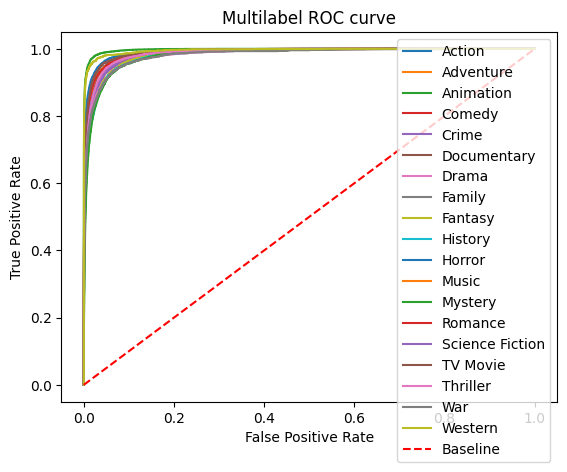

In [14]:
evaluate_auroc(test_true, test_predictions)

### Train set


              Genre   ROC AUC
0            Action  0.772649
1         Adventure  0.704379
2         Animation  0.915847
3            Comedy  0.731318
4             Crime  0.675604
5       Documentary  0.784431
6             Drama  0.682954
7            Family  0.727190
8           Fantasy  0.651671
9           History  0.666876
10           Horror  0.803042
11            Music  0.714631
12          Mystery  0.643000
13          Romance  0.715109
14  Science Fiction  0.714313
15         TV Movie  0.700536
16         Thriller  0.735189
17              War  0.733050
18          Western  0.881820
Average ROC AUC: 0.7344


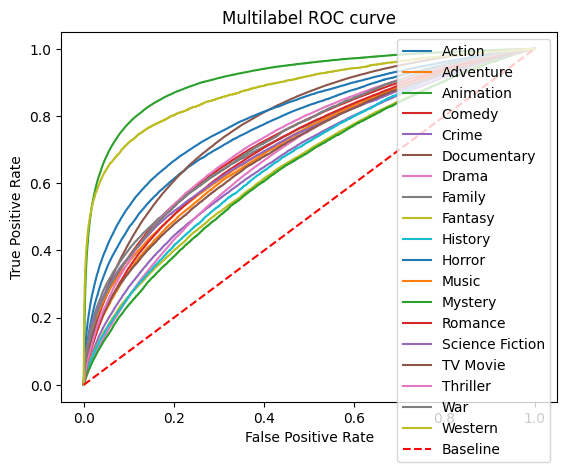

In [15]:
train_true = df.iloc[train_indices, 1:-1].to_numpy().astype(np.float32)
train_predictions = all_prediction[train_indices]

evaluate_auroc(train_true, train_predictions)

### All together


              Genre   ROC AUC
0            Action  0.820222
1         Adventure  0.765014
2         Animation  0.934342
3            Comedy  0.788724
4             Crime  0.743103
5       Documentary  0.831699
6             Drama  0.753119
7            Family  0.783249
8           Fantasy  0.721687
9           History  0.733906
10           Horror  0.845325
11            Music  0.774474
12          Mystery  0.717585
13          Romance  0.774242
14  Science Fiction  0.774028
15         TV Movie  0.762717
16         Thriller  0.790521
17              War  0.786668
18          Western  0.906741
Average ROC AUC: 0.7899


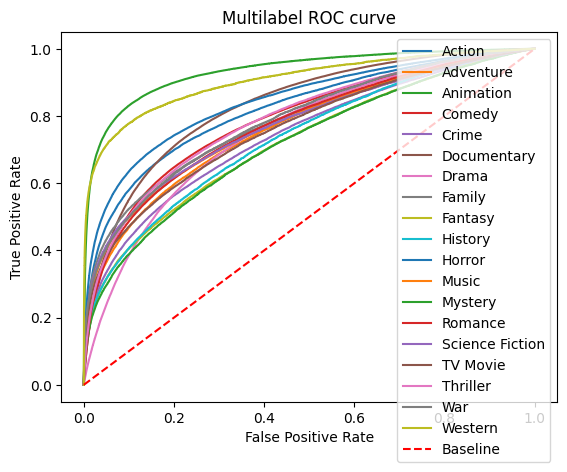

In [16]:
evaluate_auroc(df.iloc[:, 1:-1].to_numpy().astype(np.float32), all_prediction)